# HMM build and analysis

Here we will construct and analyze HMM models using MSA as the input data. We will utilize several databases as sources to enhance our analysis and gain valuable insights from the generated HMM profiles.


In [265]:
import re
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

In [328]:
# Path and input parameters
local_path = "/Users/alina/HMM/"
q_id = "Q9BZS1"
hmm_file = f'{local_path}outputs/hmms/{q_id}.hmm'
align_file = f'{local_path}outputs/alignments/blast/{q_id}_blast.fasta'

Using the alignment in .fasta format, we generate HMM model with `hmmbuild` command.

In [329]:
# Build HMM 
!hmmbuild {hmm_file} {align_file}

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             /Users/alina/HMM/outputs/alignments/blast/Q9BZS1_blast.fasta
# output HMM file:                  /Users/alina/HMM/outputs/hmms/Q9BZS1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     Q9BZS1_blast           201   431   431     0.48  0.592 

# CPU time: 0.15u 0.00s 00:00:00.15 Elapsed: 00:00:00.15


In [330]:
# Analysis of the model
!hmmstat {hmm_file}

# hmmstat :: display summary statistics for a profile file
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
#
# idx  name                 accession        nseq eff_nseq      M relent   info p relE compKL
# ---- -------------------- ------------ -------- -------- ------ ------ ------ ------ ------
1      Q9BZS1_blast         -                 201     0.48    431   0.59   0.57   0.52   0.01


In this part, we analyze the statistics of the generated HMM and focus on key metrics:
- `eff_nseq`: effective sequence number. The value is 0.44 suggesting a relatively low similarity among the sequences.
- `relent`: relative entropy of the match state. The value is 0.59, indicating a moderate conservation of residues.
- `compKL`: Kullback-Leibler divergence from the average composition. The value is low, indicating a better alignment fit with the background model. 

## 1. HMMsearch

After building the model, our objective is to assess if overlaps with the profiles in Pfam exist. Then, we enrich the model by utilizing a protein database such as the Reference Proteome. For both databases, we generate dataframes containing the most significant sequences, utilizing a default E-value threshold of 0.01.

### Pfam

If the HMMsearch against Pfam results in overlapping hits, it's a sign to analyse them more thoroughly.

In [331]:
# HMM search against Pfam
!hmmsearch {hmm_file} {local_path}databases/Pfam-A.seed > hmmsearch_pfam.txt # search against the alignments database (stockholm format)

In [332]:
with open('hmmsearch_pfam.txt', 'r') as file:
    lines = file.readlines()

# Extract the column names
column_names = ["E-value_fs", "score_fs", "bias_fs", "E-value_bd", "score_bd", "bias_bd", "exp", "N", "Sequence"]
inclusion_threshold_index = lines.index('  ------ inclusion threshold ------\n') # the E-value is 0.01

# Extract the data rows
data_rows = [line.split() for line in lines[14:inclusion_threshold_index]]

# Create the DataFrame
stats_pfam = pd.DataFrame(data_rows, columns=column_names)
len(stats_pfam)

299

In [333]:
stats_pfam.head(10)

,E-value_fs,score_fs,bias_fs,E-value_bd,score_bd,bias_bd,exp,N,Sequence
0,3.9e-45,160.5,1.6,4.2e-45,160.4,1.6,1.0,1,W5NAV6_LEPOC/337-419
1,2.9e-42,151.1,4.4,3.2e-42,151.0,4.4,1.0,1,I3M475_ICTTR/194-262
2,4.9e-34,124.0,2.7,5.3e-34,123.8,2.7,1.0,1,F7FW29_ORNAN/131-199
3,1.4e-28,106.0,3.3,1.4e-28,106.0,3.3,1.0,1,F6WAL8_MONDO/264-332
4,3.2e-21,81.7,0.0,3.6e-21,81.6,0.0,1.0,1,A0A0D2U2Q7_CAPO3/559-645
5,5.6e-21,80.9,1.5,6e-21,80.8,1.5,1.0,1,I3KJT8_ORENI/218-286
6,1e-20,80.1,0.0,1.1e-20,80.0,0.0,1.0,1,M7PKN8_PNEMU/162-248
7,3.3e-20,78.4,0.0,3.6e-20,78.3,0.0,1.0,1,T1H7Z8_RHOPR/28-114
8,7.7e-20,77.2,0.0,8.7e-20,77.0,0.0,1.0,1,T1I673_RHOPR/35-121
9,8.5e-20,77.1,0.0,9.1e-20,76.9,0.0,1.0,1,MEI4_SCHPO/80-166


The hmmsearch output displays the top hits of sequences, where a lower E-value indicates a more significant hit. In this example, a total of 143 sequences were identified as significant.

### Reference Proteome

The same procedure will be applied to the Reference Proteome database. The objective here is to enhance the quality of the model by conducting additional model training using a larger set of homologous sequences.

In [334]:
# HMM search against Reference Proteome
!hmmsearch {hmm_file} {local_path}databases/rp-seqs-15.fasta > hmmsearch_rp.txt

In [335]:
with open('hmmsearch_rp.txt', 'r') as file:
    lines = file.readlines()

# Extract the column names
column_names = lines[12].split()
inclusion_threshold_index = lines.index('  ------ inclusion threshold ------\n')

# Extract the data rows
data_rows = [line.split() for line in lines[14:inclusion_threshold_index]]
data_rows = [row[:9] + [' '.join(row[9:])] for row in data_rows]

# Create the DataFrame
stats_rp = pd.DataFrame(data_rows, columns=column_names)
len(stats_rp)

3719

In [356]:
stats_rp.head(10)

,E-value,score,bias,E-value,score,bias,exp,N,Sequence,Description
0,3.5e-298,997.6,7.3,3.9e-298,997.4,7.3,1.0,1,Q6U8D7,FOXP3_MACFA^|^^|^Forkhead box protein P3 41 kDa f
1,3.2e-297,994.4,7.8,3.5e-297,994.3,7.8,1.0,1,Q9BZS1,FOXP3_HUMAN^|^^|^Forkhead box protein P3 41 kDa f
2,4.5e-293,980.7,8.0,5e-293,980.6,8.0,1.0,1,A0A2K6S498,A0A2K6S498_SAIBB^|^^|^Forkhead box P3 {ECO:000031
3,5.2e-293,980.5,8.0,5.9e-293,980.3,8.0,1.0,1,A0A2K6S471,A0A2K6S471_SAIBB^|^^|^Forkhead box P3 {ECO:000031
4,4.8e-288,964.2,6.1,5.4e-288,964.0,6.1,1.0,1,A0A2K6S4D2,A0A2K6S4D2_SAIBB^|^^|^Forkhead box P3 {ECO:000031
5,1.9e-283,949.0,5.5,2.1e-283,948.8,5.5,1.0,1,D4Q8I1,"D4Q8I1_RAT^|^^|^Forkhead box P3 (Predicted), isof"
6,2.1e-283,948.8,23.7,4.7e-177,598.4,2.3,2.0,2,A0A2K6S477,A0A2K6S477_SAIBB^|^^|^Forkhead box P3 {ECO:000031
7,3.1e-283,948.3,5.5,3.5e-283,948.1,5.5,1.0,1,D4Q8I2,D4Q8I2_RAT^|^^|^Forkhead box P3 {ECO:0000313|Ense
8,1.2e-282,946.4,5.7,1.3e-282,946.2,5.7,1.0,1,Q99JB6,FOXP3_MOUSE^|^^|^Forkhead box protein P3 41 kDa f
9,4.5e-258,865.4,17.1,1.1e-225,758.6,2.7,2.0,2,A0A2K6S499,A0A2K6S499_SAIBB^|^^|^Forkhead box P3 {ECO:000031


## 2. HHblits

HHblits is used for profile-profile sequence alignment. It compares a profile against a target sequence database to find homologous sequences.

In [340]:
# HHblits against Pfam
!hhblits -i {align_file} -d {local_path}databases/pfam -o hhblits_pfam.txt # on alignment

- 15:45:42.101 INFO: Searching 19632 column state sequences.

- 15:45:42.731 INFO: /Users/alina/HMM/outputs/alignments/blast/Q9BZS1_blast.fasta is in A2M, A3M or FASTA format

- 15:45:42.734 INFO: Iteration 1

- 15:45:42.927 INFO: Prefiltering database

- 15:45:43.303 INFO: HMMs passed 1st prefilter (gapless profile-profile alignment)  : 730

- 15:45:43.313 INFO: HMMs passed 2nd prefilter (gapped profile-profile alignment)   : 253

- 15:45:43.313 INFO: HMMs passed 2nd prefilter and not found in previous iterations : 253

- 15:45:43.313 INFO: Scoring 253 HMMs using HMM-HMM Viterbi alignment

- 15:45:43.351 INFO: Alternative alignment: 0

- 15:45:49.253 INFO: 253 alignments done

- 15:45:49.253 INFO: Alternative alignment: 1

- 15:45:50.836 INFO: 45 alignments done

- 15:45:50.836 INFO: Alternative alignment: 2

- 15:45:50.922 INFO: 3 alignments done

- 15:45:50.922 INFO: Alternative alignment: 3

- 15:45:51.612 INFO: Premerge done

- 15:45:51.612 INFO: Realigning 10 HMM-HMM alignments u

- `Hit`: contains information about Pfam identifier (starts with PF...), the abbreviated and full name of the domain.
- `Prob`: the probability of the match between the query sequence and the template sequence.
- `E-value`: the expected number of false positive matches that could occur by chance.
- `P-value`: the probability of obtaining a match with a score as good as or better than the observed score purely by chance.
Similar as `E-value`, the lower `P-value` indicate more significant matches.
- `Score`: the quality of the alignment between the query and template sequences.
- `SS (Secondary Structure)`: the predicted secondary structure of the aligned residues in the template sequence.
- `Cols`: the number of aligned columns or residues in the alignment between the query and template sequences.
- `Query HMM`: indicates position matches within HMM profile (input).
- `Template HMM`: indicates position matches within HMM profile (database).
Usually the length of template HMM is bigger than the length of query HMM.

In [350]:
with open('hhblits_pfam.txt', 'r') as file:
    lines = file.readlines()

# Extract the column names
column_names = lines[8].split()[:-4] + ['Query HMM', 'Template HMM']

# Extract the data rows
data_rows = [line.split() for line in lines[9:19]] 
data_rows = [[row[0]] + [' '.join(row[1:4])] + row[7:14] + [' '.join(row[14:16])] 
             for row in data_rows]

# Create the DataFrame
hhblits_stats = pd.DataFrame(data_rows, columns=column_names)
hhblits_stats.tail(10)

,No,Hit,Prob,E-value,P-value,Score,SS,Cols,Query HMM,Template HMM
0,1,PF16159.8 ; FOXP-CC,99.8,7.7E-26,1.7E-29,171.1,0.0,68,193-260,1-68 (69)
1,2,PF00250.21 ; Forkhead,1.7E-13,4.4E-17,95.2,0.0,76,337-412,2-85,(90)
2,3,PF18366.4 ; zf_ZIC,94.7,0.00023,5.7E-08,43.2,0.0,31,194-224,5-44 (46)
3,4,PF18217.4 ; Zap1_zf2,94.4,0.00034,9E-08,33.4,0.0,24,199-222,1-24 (24)
4,5,PF17726.4 ; DpnI_C,2.5,0.0006,25.5,0.0,51,341-392,4-54,(70)
5,6,PF13894.9 ; zf-C2H2_4,2.4,0.00074,13.8,0.0,10,199-208,3-12,(24)
6,7,PF17017.8 ; zf-C2H2_aberr,3.5,0.001,24.7,0.0,28,197-224,138-165,(173)
7,8,PF12013.11 ; OrsD,11,0.0028,22.8,0.0,28,193-222,81-108,(109)
8,9,PF01608.20 ; I_LWEQ,9.6,14,0.0034,25.4,0.0,29,230-258,117-145 (149)
9,10,PF19126.3 ; DUF5810,8.7,17,0.0038,22.5,0.0,28,200-227,4-31 (66)


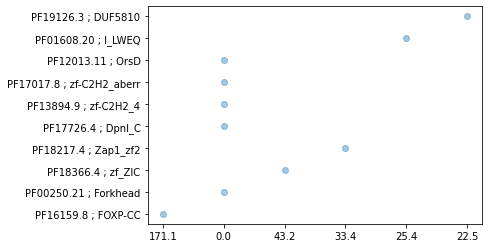

In [355]:
plt.scatter(hhblits_stats['Score'], hhblits_stats['Hit'], alpha=0.4)
plt.show()